In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

In [2]:
def StockPrices(S0, r, sd, T, paths, steps):
    
    dt = T/steps
    
    # Generate stochastic process and its antithetic paths
    Z = np.random.normal(0, 1, paths//2 * steps).reshape((paths//2, steps))
    Z_inv = -Z
    
    dWt = math.sqrt(dt) * Z
    dWt_inv = math.sqrt(dt) * Z_inv
    
    # bind the normal and antithetic Wt
    dWt = np.concatenate((dWt, dWt_inv), axis=0)
    
    St = np.zeros((paths, steps + 1))
    St[:, 0] = S0
    
    for i in range (1, steps + 1):
        St[:, i] = St[:, i - 1]*np.exp((r - 1/2*np.power(sd, 2))*dt + sd*dWt[:, i - 1])
    
    return St[:, 1:]

In [3]:
def laguerre_polynomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.exp(-S/2)
    x2 = np.exp(-S/2) * (1 - S)
    x3 = np.exp(-S/2) * (1 - 2*S + S**2/2)
    x4 = np.exp(-S/2) * (1 - 3*S + 3* S**2/2 - S**3/6)
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

In [4]:
def hermite_polynomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.ones(S.shape)
    x2 = 2*S
    x3 = 4*S**2 - 2
    x4 = 8*S**3 - 12
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

In [5]:
def monomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.ones(S.shape)
    x2 = S
    x3 = S**2
    x4 = S**3 
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

In [6]:
def LSMC(S0, K, r, sd, T, paths, k, polynomials):
    
    mult = 50
    steps = int(mult*T)
    St = StockPrices(S0, r, sd, T, paths, steps)/K
    dt = T/steps

    # initialize cash flow matrix
    cashFlow = np.zeros((paths, steps))
    cashFlow[:,steps - 1] = np.maximum(1 - St[:,steps - 1], 0)

    # initialize continuation value matrix
    cont_value = cashFlow

    # initialize stopping time matrix
    decision = np.zeros((paths, steps))
    decision[:, steps - 1] = 1

    # build discount factor
    discountFactor = np.tile(np.exp(-r*dt* np.arange(1, 
                                    steps + 1, 1)), paths).reshape((paths, steps))

    for i in reversed(range(steps - 1)):

        # Find in the money paths
        in_the_money_n = np.where(1 - St[:, i] > 0)[0]
        out_of_money_n = np.asarray(list(set(np.arange(paths)) 
                                            - set(in_the_money_n)))

        #  Use the first k terms of Laguerre Polynomials
        if polynomials == 'laguerre':
            X = laguerre_polynomials(St[in_the_money_n, i], k)
            
        elif polynomials == 'hermite':
            X = hermite_polynomials(St[in_the_money_n, i], k)
            
        elif polynomials == 'monomials':
            X = monomials(St[in_the_money_n, i], k)
        else:
            print ('Error: Please Choose the Right Polynomials to Estimate')
            
            
        Y = cashFlow[in_the_money_n, i + 1]/np.exp(r*dt)

        # Find Least Square Beta
        A = np.dot(X.T, X)
        b = np.dot(X.T, Y)
        Beta = np.dot(np.linalg.pinv(A), b)

        # find continuation value
        cont_value[in_the_money_n,i] =  np.dot(X, Beta)
        try:
            cont_value[out_of_money_n,i] =  cont_value[out_of_money_n, i + 1]/np.exp(r*dt)
        except:
            pass

        # update decision rule
        decision[:, i] = np.where(np.maximum(1 - St[:, i], 0)  - cont_value[:,i] >= 0, 1, 0)
        
        # update cash flow matrix
        cashFlow[:, i] =  np.maximum(1 - St[:, i], cont_value[:,i])
    
    # Find the first occurence of 1, indicating the early exercise date
    first_exercise = np.argmax(decision, axis = 1) 
    decision = np.zeros((len(first_exercise), steps))
    decision[np.arange(len(first_exercise)), first_exercise] = 1
    
    option_value = np.mean(np.sum(decision*discountFactor*cashFlow*K, axis = 1))
    
    return option_value

In [7]:
sd = 0.25
r = 0.04
paths = 100000 
K = 40
np.random.seed(7)

S0 = [36, 40, 44]
T = [0.5, 1, 2]
k = [2, 3, 4]

In [8]:
American_put_values_laguerre = {}
for s in S0:
    for t in T:
        for i in k:
            
            American_put_values_laguerre[(s, t, i)] = round(LSMC(s, K, r, sd, t, paths, i, 'laguerre'), 5)
columns = ['Initial Price (S0)', 'Maturity T', 'Num terms (k)', 'Value Laguerre ($)']
American_put_laguerre = pd.concat([pd.DataFrame(list(American_put_values_laguerre.keys())), 
            pd.DataFrame(list(American_put_values_laguerre.values()))], axis  = 1)
American_put_laguerre.columns = columns

In [9]:
American_put_values_hermite = {}
for s in S0:
    for t in T:
        for i in k:
            American_put_values_hermite[(s, t, i)] = round(LSMC(s, K, r, sd, t, paths, i, 'hermite'), 5)
columns = ['Initial Price (S0)', 'Maturity T', 'Num terms (k)', 'Value Hermite ($)']
American_put_hermite = pd.concat([pd.DataFrame(list(American_put_values_hermite.keys())), 
            pd.DataFrame(list(American_put_values_hermite.values()))], axis  = 1)
American_put_hermite.columns = columns

In [10]:
American_put_values_monomials = {}
for s in S0:
    for t in T:
        for i in k:
            American_put_values_monomials[(s, t, i)] = round(LSMC(s, K, r, sd, t, paths, i, 'monomials'), 5)
            
columns = ['Initial Price (S0)', 'Maturity T', 'Num terms (k)', 'Value Monomial ($)']
American_put_monomials = pd.concat([pd.DataFrame(list(American_put_values_monomials.keys())), 
            pd.DataFrame(list(American_put_values_monomials.values()))], axis  = 1)
American_put_monomials.columns = columns
AM_put = pd.concat([American_put_laguerre, American_put_hermite['Value Hermite ($)'], 
           American_put_monomials['Value Monomial ($)']], axis= 1)
AM_put

,Initial Price (S0),Maturity T,Num terms (k),Value Laguerre ($),Value Hermite ($),Value Monomial ($)
0,36,0.5,2,4.69845,4.65628,4.65608
1,36,0.5,3,4.71213,4.72139,4.71413
2,36,0.5,4,4.72749,4.72942,4.72704
3,36,1.0,2,5.29461,5.19893,5.19012
4,36,1.0,3,5.32650,5.33246,5.33404
5,36,1.0,4,5.33778,5.34953,5.34206
6,36,2.0,2,6.05673,5.84644,5.85239
7,36,2.0,3,6.12041,6.11927,6.13739
8,36,2.0,4,6.15195,6.16693,6.16239
9,40,0.5,2,2.47230,2.44212,2.44323


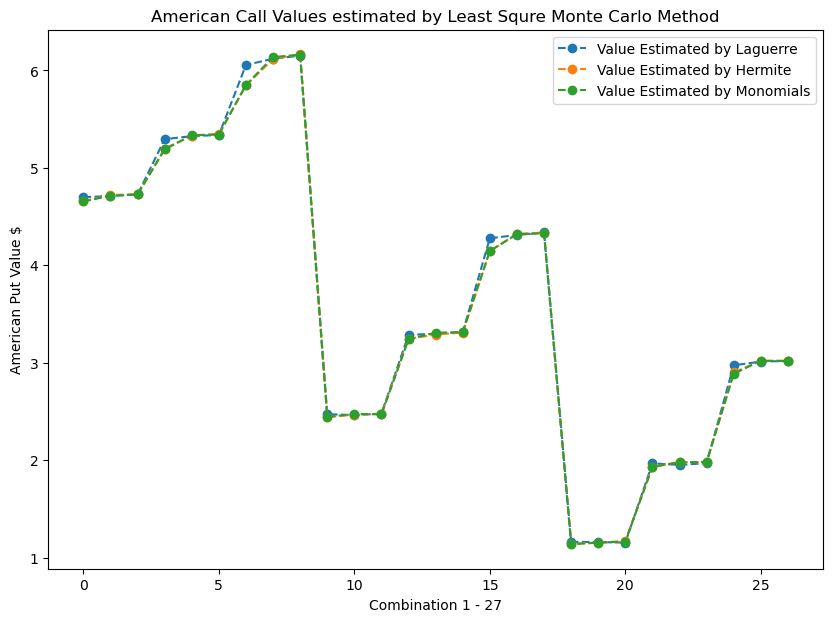

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(AM_put['Value Laguerre ($)'],  linestyle='--', 
         marker='o', label = 'Value Estimated by Laguerre')

plt.plot(AM_put['Value Hermite ($)'],   linestyle='--',
         marker='o', label = 'Value Estimated by Hermite')

plt.plot(AM_put['Value Monomial ($)'],  linestyle='--',  
         marker='o',label = 'Value Estimated by Monomials')

plt.legend()
plt.xlabel('Combination 1 - 27')
plt.ylabel('American Put Value $')
plt.title('American Call Values estimated by Least Squre Monte Carlo Method')
plt.show()

## Forward Start Options

In [12]:
sd = 0.2
r = 0.06
paths = 100000
K = 60
S0 = 65
T = 1
t = 0.2
np.random.seed(7)

def forwardStart_European(S0, t, r, sd, T, paths):
    
    mult = 252
    steps = int(mult*T)
    St = StockPrices(S0, r, sd, T, paths, steps)
    dt = T/steps 
    
    # Determine Strike Pices of each paths
    K = St[:, int(mult* t)]
    
    # Find the option value for each paths at time T
    cashFlow = np.maximum(K - St[:,steps - 1], 0)
    option_value = np.mean(cashFlow)*np.exp(-r*t)
    
    return option_value
print("The value of forward start European Option: $", round(forwardStart_European(S0, t, r, sd, T, paths), 5))

The value of forward start European Option: $ 3.31237


In [13]:
def forwardStart_put_LSMC(S0, t, r, sd, T, paths):
    
    mult = 252
    steps = int(mult*T)
    St = StockPrices(S0, r, sd, T, paths, steps)
    dt = T/steps

    # Determine Strike Pices of each paths
    K = St[:, int(mult* t)]
    
    # initialize cash flow matrix
    cashFlow = np.zeros((paths, steps))
    cashFlow[:,steps - 1] = np.maximum(K - St[:,steps - 1], 0)/K

    # initialize continuation value matrix
    cont_value = cashFlow

    # initialize stopping time matrix
    decision = np.zeros((paths, steps))
    decision[:, steps - 1] = 1

    # build discount factor
    discountFactor = np.tile(np.exp(-r*dt* np.arange(1, 
                                    steps + 1, 1)), paths).reshape((paths, steps))
    
    for i in reversed(range(int(t*steps), (steps - 1))):

        # Find in the money paths
        in_the_money_n = np.where(K - St[:, i] > 0)[0]
        out_of_money_n = np.asarray(list(set(np.arange(paths)) 
                                            - set(in_the_money_n)))

        X = monomials(np.divide(St[in_the_money_n, i],K[in_the_money_n]), 4)            
        Y = cashFlow[in_the_money_n, i + 1]/np.exp(r*dt)

        # Find Least Square Beta
        A = np.dot(X.T, X)
        b = np.dot(X.T, Y)
        Beta = np.dot(np.linalg.pinv(A), b)

        # find continuation value
        cont_value[in_the_money_n,i] =  np.dot(X, Beta)
        try:
            cont_value[out_of_money_n,i] =  cont_value[out_of_money_n, i + 1]/np.exp(r*dt)
        except:
            pass

        # update decision rule
        decision[:, i] = np.where(np.maximum(K - St[:, i], 0)  - cont_value[:,i] >= 0, 1, 0)
        
        # update cash flow matrix
        cashFlow[:, i] =  np.maximum((K - St[:, i])/K, cont_value[:,i])
    
    # Find the first occurence of 1, indicating the early exercise date
    first_exercise = np.argmax(decision, axis = 1) 
    decision = np.zeros((len(first_exercise), steps))
    decision[np.arange(len(first_exercise)), first_exercise] = 1
    
    option_value = np.mean(np.sum(decision*discountFactor*cashFlow* np.tile(K.reshape((paths, 1)), steps), axis = 1))
    
    return option_value
sd = 0.2
r = 0.06
paths = 100000
K = 60
S0 = 65
T = 1
t = 0.2
np.random.seed(7)
print("The value of forward start American Put Option: $", round(forwardStart_put_LSMC(S0, t, r, sd, T, paths), 5))

The value of forward start American Put Option: $ 3.52117
